## De Werf/Diep/Jamieson Human Pediatric AML Study in Progenitors and Hematopoietic Stem Cells 
### Progenitors
* Pediatric AML vs Adult AML
* Pediatric AML vs Pediatric Non-leukemia

### Stem Cells
* Pediatric AML vs Adult AML
* Pediatric AML vs Pediatric Non-leukemia


# RNASeq Differential Expression Testing and Visualization

   > * Tom Whisenant, CCBB (twhisenant@ucsd.edu)
   > * Based on upstream analysis by Guorong Xu, CCBB (g1xu@ucsd.edu)
</div>

* Modeled on "RNA-seq analysis is easy as 1-2-3 with limma, Glimma and edgeR" ([1](#Citations))


## Parameter Input

In [1]:
# Available on request due to size limits
gPreviousStepRdataFp =  "../data/20200228_DeWerf_Human_PediatricAML_data_exploration_20200327141050.RData"                          

[Table of Contents](#Table-of-Contents)

## Library Import

Import the necessary R, Bioconductor, and CCBB libraries for the analysis:

In [2]:
library('IRdisplay')
library('RColorBrewer')
library('limma')
library('edgeR')
library('Glimma')
library('ggplot2')
library('ggpubr')
library('org.Hs.eg.db')
library('genefilter')
library('Homo.sapiens')
library('splitstackshape')
library('statmod')
library('plyr')
library('dplyr')
library('gdata')
library('reshape2')
library("gplots")
EG2SYM <- toTable(org.Hs.egSYMBOL)
ENS2EG <- toTable(org.Hs.egENSEMBL2EG)
ENS2EG2SYM <- data.frame(gene_id=ENS2EG$gene_id, ens_id=ENS2EG, 
                         SYM=EG2SYM[match(ENS2EG$gene_id,EG2SYM$gene_id),"symbol"])

Warning message:
“package ‘IRdisplay’ was built under R version 4.1.0”
Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, r

In [3]:
gSourceDir = "src/" # note trailing slash here but not below
# Import shared source code to load and save previous notebooks' environments:
source(paste0(gSourceDir, "ChainedNotebookSupport.R"))
# Import the previous step's state:
gPreviousStepEnv = loadToEnvironment(gPreviousStepRdataFp)

In [4]:
# Load relevant variables:
gProjectName = gPreviousStepEnv$gProjectName
gDgeList = gPreviousStepEnv$gDgeList
gGeneIdCol = gPreviousStepEnv$gGeneIdCol

Populate the run name parameter automatically to ensure that outputs from different runs do not overwrite each other:

In [5]:
gRunName = makeRunName(gProjectName, "differential_expression")
gRunName

[1] "20200228_DeWerf_Human_PediatricAML_differential_expression_20230124225017"

In [6]:
source(paste0(gSourceDir, "PcaPlotter.R"))
source(paste0(gSourceDir, "CountsPcaPlotter.R"))


Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend




In [7]:
# This cell supports future resizing of the plots in the Jupyter notebook
gDefaultWidth = getOption("repr.plot.width")
gDefaultHeight = getOption("repr.plot.height")
resetPlotSize = function(){
    options(repr.plot.width=gDefaultWidth, repr.plot.height=gDefaultHeight)
}

In [8]:
# This line prevents SVG output, which interacts badly with export to HTML
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

In [9]:
gDgeList.prog <- gPreviousStepEnv$gDgeList.prog
gDgeList.stem <- gPreviousStepEnv$gDgeList.stem

In [10]:
gNormedFilteredDgeList.prog <- gPreviousStepEnv$gNormedFilteredDgeList.prog
gNormedFilteredDgeList.stem <- gPreviousStepEnv$gNormedFilteredDgeList.stem

In [11]:
generateGroupMeansDesignModel = function(designDf){

    design_levels.prim <- designDf[["group"]]
    unique_levels.prim <- unique(design_levels.prim)
    design_levels.sec <- paste0("x", designDf[["SequenceDate"]])
    unique_levels.sec <- unique(design_levels.sec)
    f.prim = factor(design_levels.prim, levels=unique_levels.prim)
    f.sec = factor(design_levels.sec, levels=unique_levels.sec)
    #designModel = model.matrix(~0 + f.prim + f.sec)
    designModel = model.matrix(~0 + f.prim)
    rownames(designModel) = designDf[["Sample"]] # or potentially rownames(designDf)
    colnames(designModel) = gsub("f.prim|f.sec", "", gsub("/", "", colnames(designModel)))

    return(designModel)
}


In [12]:
gDesignModel.prog = generateGroupMeansDesignModel(gNormedFilteredDgeList.prog$samples)
gDesignModel.stem = generateGroupMeansDesignModel(gNormedFilteredDgeList.stem$samples)

[Table of Contents](#Table-of-Contents)

### Contrast Creation

Depending on how the design model is defined, its terms may not always directly address the group comparisons of interest.  Therefore, it is possible to define "contrasts", or differences of terms.  Contrasts allow you to "take the initial coefficients and compare them in as many ways as you want to answer any questions you might have,
regardless of how many or how few these might be." ([8](#Citations))

In [13]:
gContrastMatrix.prog = makeContrasts(
    
    PedAMLvsAdultAML = PedAML - AdultAML,
    PedAMLvsPedNL = PedAML - PedNL,
    levels=colnames(gDesignModel.prog))

gContrastMatrix.stem = makeContrasts(
    
    PedAMLvsAdultAML = PedAML - AdultAML,
    PedAMLvsPedNL = PedAML - PedNL,
    levels=colnames(gDesignModel.stem))

In [14]:
gVoomResult.prog = voom(gNormedFilteredDgeList.prog, gDesignModel.prog, plot=FALSE)
gVoomResult.stem = voom(gNormedFilteredDgeList.stem, gDesignModel.stem, plot=FALSE)

[Table of Contents](#Table-of-Contents)

### Fitting of Linear Models

Fit a separate linear model to the expression values of each gene, and apply empirical Bayes moderation to improve the estimates of gene-wise variability by borrowing information across genes.

In [15]:
gVoomedFit.prog = lmFit(gVoomResult.prog, gDesignModel.prog)
gVoomedFit.stem = lmFit(gVoomResult.stem, gDesignModel.stem)

In [16]:
gVoomedFitForContrasts.prog = contrasts.fit(gVoomedFit.prog, contrasts=gContrastMatrix.prog)
gVoomedFitForContrasts.stem = contrasts.fit(gVoomedFit.stem, contrasts=gContrastMatrix.stem)

In [17]:
gModeratedVoomedFitForContrasts.prog = eBayes(gVoomedFitForContrasts.prog)
gModeratedVoomedFitForContrasts.stem = eBayes(gVoomedFitForContrasts.stem)

In [18]:
topTable_PedAMLvsAdultAML_Prog = read.table(file="../data/topTable_DEgenes_PedAMLvsAdultAML_Prog_2021original.txt", sep="\t", header=TRUE)
topTable_PedAMLvsPedNL_Prog = read.table(file="../data/topTable_DEgenes_PedAMLvsPedNL_Prog_2021original.txt", sep="\t", header=TRUE)
topTable_PedAMLvsAdultAML_Stem = read.table(file="../data/topTable_DEgenes_PedAMLvsAdultAML_Stem_2021original.txt", sep="\t", header=TRUE)
topTable_PedAMLvsPedNL_Stem = read.table(file="../data/topTable_DEgenes_PedAMLvsPedNL_Stem_2021original.txt", sep="\t", header=TRUE)

In [19]:
gGroupMetadataColName1 = "Phenotype"
gGroupMetadataColName2 = "group"

In [20]:
gGroupMetadataVector.prog = as.character(gNormedFilteredDgeList.prog$samples[[gGroupMetadataColName2]])
gGroupMetadataVector.stem = as.character(gNormedFilteredDgeList.stem$samples[[gGroupMetadataColName2]])

## Fig 3a, b - Boxplot of LSC Markers

In [21]:
lcpm.prog <- cpm(gNormedFilteredDgeList.prog, log=TRUE)
lcpm.stem <- cpm(gNormedFilteredDgeList.stem, log=TRUE)

Using group as id variables

Using group as id variables

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


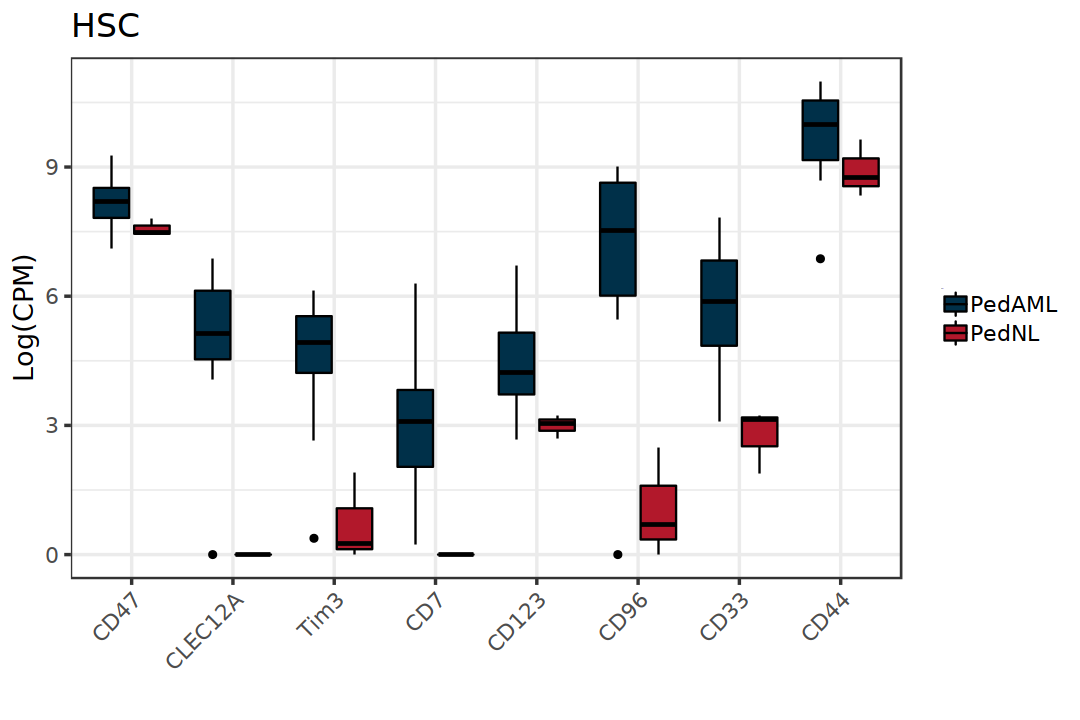

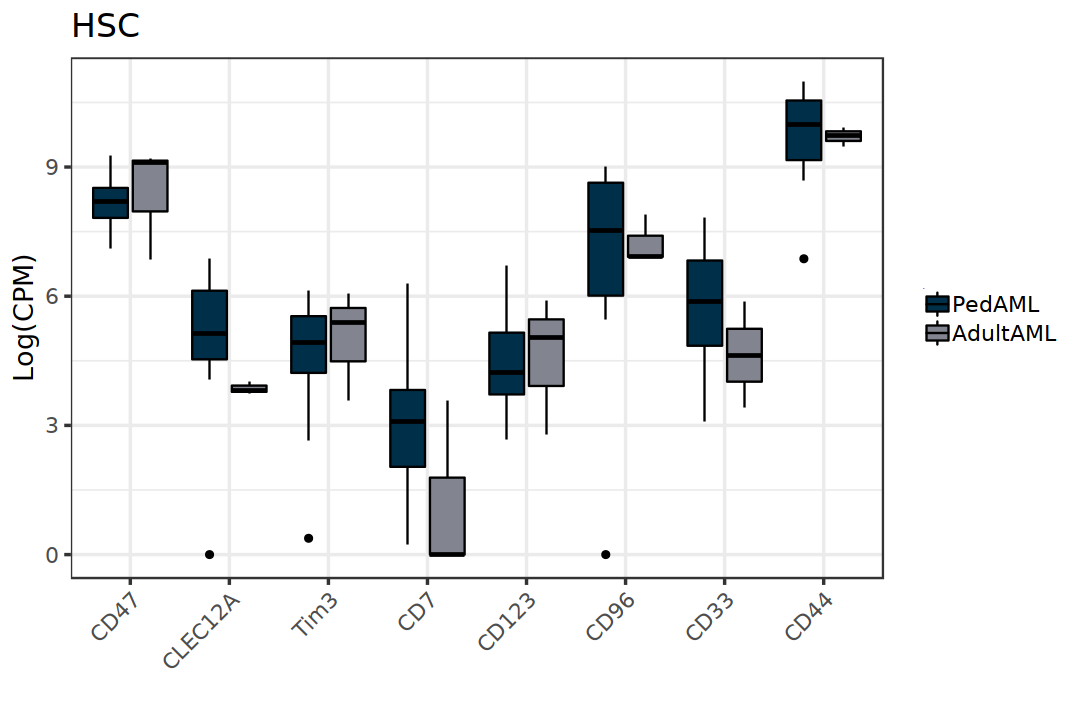

In [22]:
LSC.lcpm.prog <- cbind(gNormedFilteredDgeList.prog$samples, 
                       t(lcpm.prog[rownames(lcpm.prog) %in% "ENSG00000196776",,drop=FALSE]),
                       t(lcpm.prog[rownames(lcpm.prog) %in% "ENSG00000172322",,drop=FALSE]),
                       t(lcpm.prog[rownames(lcpm.prog) %in% "ENSG00000135077",,drop=FALSE]),
                       t(lcpm.prog[rownames(lcpm.prog) %in% "ENSG00000173762",,drop=FALSE]),
                       t(lcpm.prog[rownames(lcpm.prog) %in% "ENSG00000185291",,drop=FALSE]),
                       t(lcpm.prog[rownames(lcpm.prog) %in% "ENSG00000153283",,drop=FALSE]),
                       t(lcpm.prog[rownames(lcpm.prog) %in% "ENSG00000105383",,drop=FALSE]),
                       t(lcpm.prog[rownames(lcpm.prog) %in% "ENSG00000026508",,drop=FALSE]))

LSC.lcpm.stem <- cbind(gNormedFilteredDgeList.stem$samples, 
                       t(lcpm.stem[rownames(lcpm.stem) %in% "ENSG00000196776",,drop=FALSE]),
                       t(lcpm.stem[rownames(lcpm.stem) %in% "ENSG00000172322",,drop=FALSE]),
                       t(lcpm.stem[rownames(lcpm.stem) %in% "ENSG00000135077",,drop=FALSE]),
                       t(lcpm.stem[rownames(lcpm.stem) %in% "ENSG00000173762",,drop=FALSE]),
                       t(lcpm.stem[rownames(lcpm.stem) %in% "ENSG00000185291",,drop=FALSE]),
                       t(lcpm.stem[rownames(lcpm.stem) %in% "ENSG00000153283",,drop=FALSE]),
                       t(lcpm.stem[rownames(lcpm.stem) %in% "ENSG00000105383",,drop=FALSE]),
                       t(lcpm.stem[rownames(lcpm.stem) %in% "ENSG00000026508",,drop=FALSE]))

colnames(LSC.lcpm.prog)[18:25] <- c("CD47", "CLEC12A", "Tim3", "CD7", "CD123", "CD96", "CD33", "CD44")
colnames(LSC.lcpm.stem)[18:25]<- c("CD47","CLEC12A", "Tim3", "CD7", "CD123", "CD96", "CD33", "CD44")
for (i in 18:25) {
    LSC.lcpm.prog[which(LSC.lcpm.prog[,i] < 0),i] <- 0 
    LSC.lcpm.stem[which(LSC.lcpm.stem[,i] < 0),i] <- 0     
}
LSC.lcpm.prog.m <- melt(LSC.lcpm.prog[,-c(2:17)])
LSC.lcpm.stem.m <- melt(LSC.lcpm.stem[,-c(2:17)])

LSC.lcpm.prog.m.filt <- LSC.lcpm.prog.m[LSC.lcpm.prog.m$group %in% c("PedAML", "AdultAML"),]
LSC.lcpm.prog.m.filt$group <- factor(as.character(LSC.lcpm.prog.m.filt$group),
                                    levels=c("PedAML", "AdultAML"))
options(repr.plot.width=9, repr.plot.height=6)
ggboxplot(subset(LSC.lcpm.stem.m, group != "AdultAML"), x="variable", y="value", fill="group", palette=c("#003049","#B2182B"), remove="legend") + 
    theme_bw(base_size=16) +  ylab("Log(CPM)") + ylim(0,11) + xlab("") +
    labs(title="HSC") + theme(legend.title=element_text(size=0)) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

LSC.lcpm.stem.m.filt <- LSC.lcpm.stem.m[LSC.lcpm.stem.m$group %in% c("PedAML", "AdultAML"),]
LSC.lcpm.stem.m.filt$group <- factor(as.character(LSC.lcpm.stem.m.filt$group),
                                    levels=c("PedAML", "AdultAML"))

options(repr.plot.width=9, repr.plot.height=6)
ggboxplot(LSC.lcpm.stem.m.filt, x="variable", y="value", fill="group", palette=c("#003049","#82858F"), remove="legend") + 
    theme_bw(base_size=16) + ylab("Log(CPM)") + ylim(0,11) + xlab("") +
    labs(title="HSC") + theme(legend.title=element_text(size=0)) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 


[Table of Contents](#Table-of-Contents)

## plotTopHeatmapForGenelist

In [23]:
plotTopHeatmapForGenelist = function(aFit, aVoomResults, genelist, 
                                        outputDir, runName, metadataVector, description, 
                                        coeffNumber, geneNaId, expGroups=c("PedAML", "PedNL"), id="SYMBOL", 
                                     colid="Sample_ID"){
    
    allHits = topTreat(aFit, coef=coeffNumber, n=Inf)
    topHits = allHits[allHits[[id]] %in% genelist,]
    i = which(aVoomResults$genes[[geneNaId]] %in% topHits[[geneNaId]])
    mycol = colorpanel(1000, "blue", "white", "red")
    if (tolower(expGroups) == "all") {
        subGroups <- which(metadataVector %in% metadataVector) #Take all samples
    } else {
        subGroups <- which(metadataVector %in% expGroups)
    }
    
    f <- as.factor(as.character(metadataVector[subGroups]))
    if(length(levels(f)) == 2) {
        if(sum(expGroups %in% c("PedAML", "PedNL")) == 2 ) {
            group_col = c("#11142F","#B2182B")[f] # PedAML & PedNL
        } else if(sum(expGroups %in% c("PedAML", "AdultAML")) == 2){
            group_col = c("#82858F","#11142F")[f] # Adult AML & PedAML
        } else if(sum(expGroups %in% c("PedAML", "sAML")) == 2) {
            group_col = c("#D9854C","#11142F")[f] # sAML & PedAML
        } else {
            group_col = c("#11142F","#B2182B")[f]
        }
    } else {
        group_col <- c("#f77f00","#003049", "#B2182B", "snow3")[f]
    }
    geneNames <- aVoomResults$genes[[id]][i]
    symbolNaIdx <- which(is.na(aVoomResults$genes[[id]][i]))
    geneNames[symbolNaIdx] <- aVoomResults$genes[[geneNaId]][symbolNaIdx]
    makeCustomHeatmap = function(){
        heatmap.2(aVoomResults$E[i,subGroups], scale="row", labRow=geneNames, 
                 labCol=aVoomResults$targets[[colid]][subGroups], # May need to change to represent variable containing sample name
                 ColSideColors=group_col,
                 col=mycol, trace="none", density.info="none", dendrogram="column",
                 margin=c(8,8), lhei=c(2,10), key=FALSE)  
    }
    makeCustomHeatmap()
}

In [24]:
TabS3_vanGal_T_Pl <- read.csv(file="../data/TableS3_vanGalenetal_Tumor_Prog_Like.csv", header=TRUE)
TabS3_vanGal_T_Hl <- read.csv(file="../data/TableS3_vanGalenetal_Tumor_HSC_Like.csv", header=TRUE)

## Fig S3b - Heatmap of Van Galen Genes, PedAML vs AdultAML (HSC, HPC)

Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”


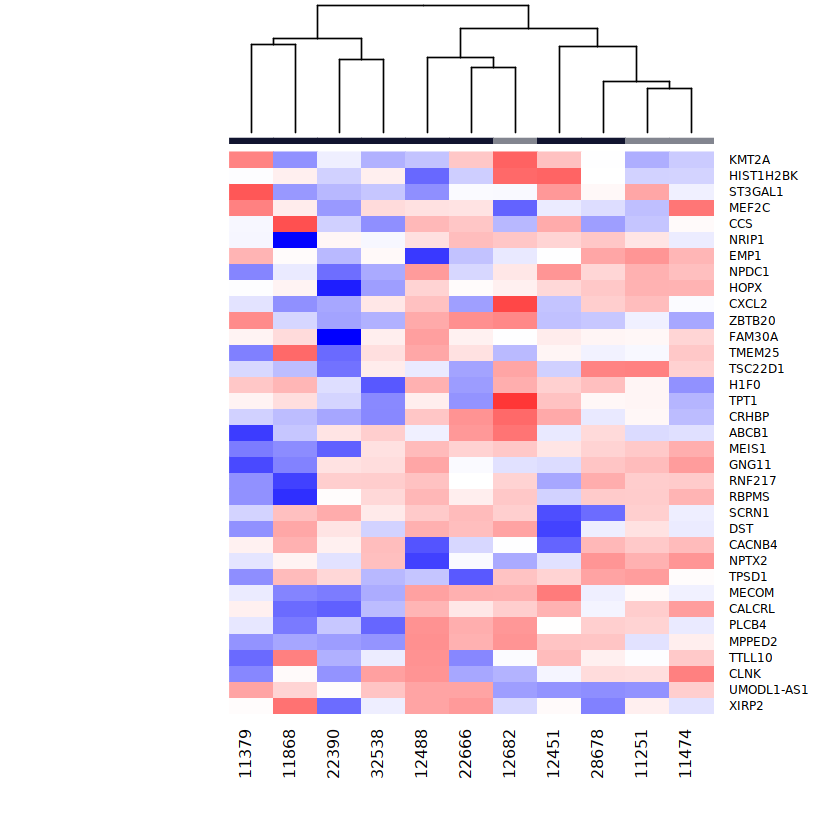

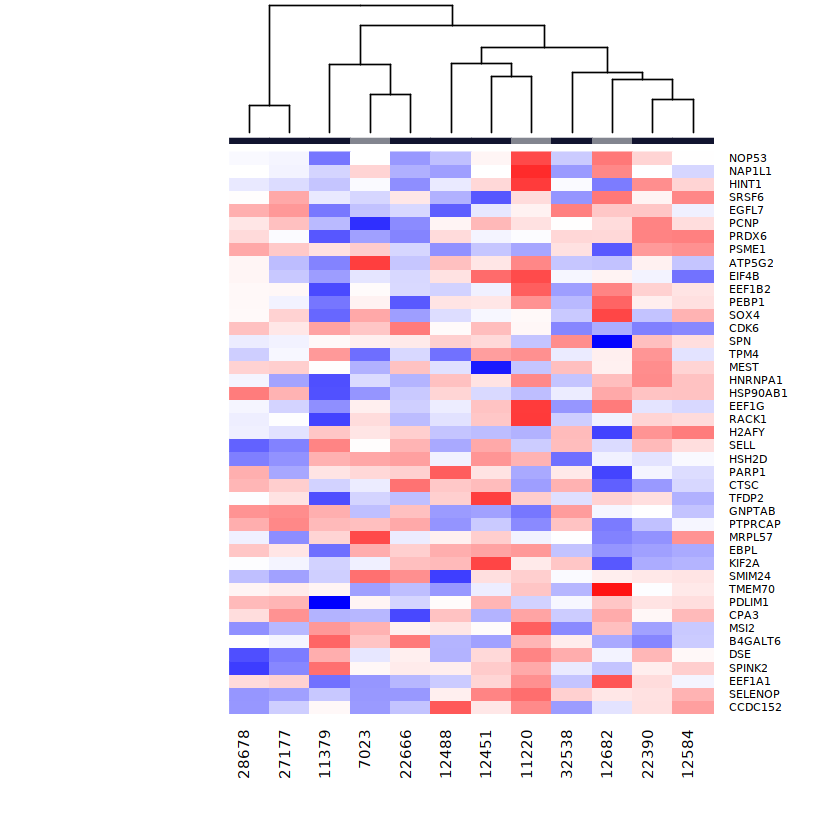

In [25]:
options(repr.plot.width=7, repr.plot.height=7)
plotTopHeatmapForGenelist(gModeratedVoomedFitForContrasts.stem, gVoomResult.stem, 
                          genelist=TabS3_vanGal_T_Hl[,1], geneNaId="SYMBOL", outputDir=gOutputDir,
                          metadataVector=gGroupMetadataVector.stem, coeffNumber=1, expGroups=c("PedAML", "AdultAML"), 
                          colid="Patient.ID")

options(repr.plot.width=7, repr.plot.height=7)
plotTopHeatmapForGenelist(gModeratedVoomedFitForContrasts.prog, gVoomResult.prog, 
                          genelist=TabS3_vanGal_T_Pl[,1], geneNaId="SYMBOL", outputDir=gOutputDir,
                          metadataVector=gGroupMetadataVector.prog, coeffNumber=1, expGroups=c("PedAML", "AdultAML"), 
                          colid="Patient.ID")

## Figure S3c - Heatmap of Van Galen Genes, PedAML vs PedNL (HSC)

Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”


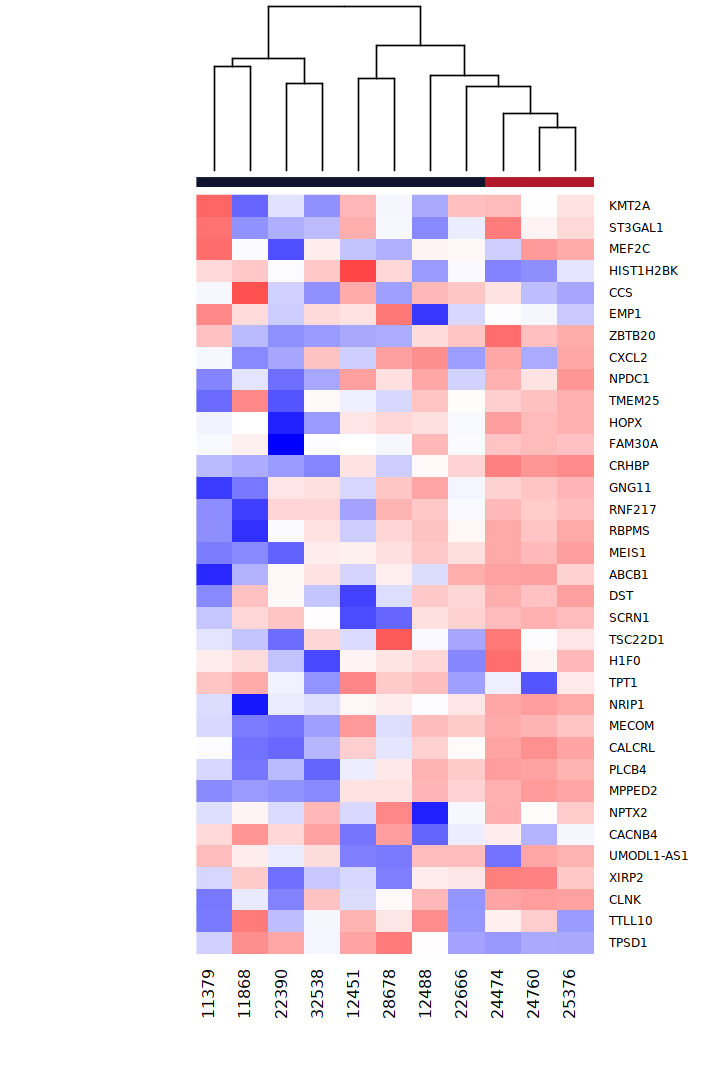

In [26]:
options(repr.plot.width=6, repr.plot.height=9)
plotTopHeatmapForGenelist(gModeratedVoomedFitForContrasts.stem, gVoomResult.stem, 
                          genelist=TabS3_vanGal_T_Hl[,1], geneNaId="SYMBOL", outputDir=gOutputDir,
                          metadataVector=gGroupMetadataVector.stem, coeffNumber=2, expGroups=c("PedAML", "PedNL"), 
                          colid="Patient.ID")


## Figure S3c - Heatmap of Van Galen Genes, PedAML vs PedNL (HPC)

Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”


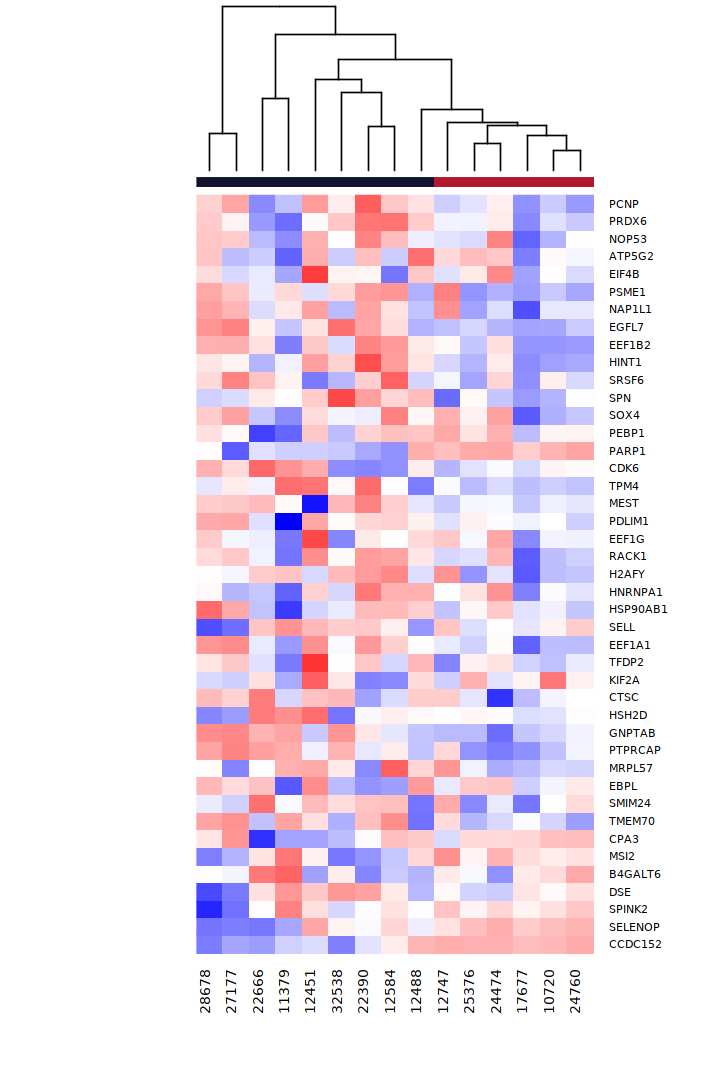

In [27]:
options(repr.plot.width=6, repr.plot.height=9)
plotTopHeatmapForGenelist(gModeratedVoomedFitForContrasts.prog, gVoomResult.prog, 
                          genelist=TabS3_vanGal_T_Pl[,1], geneNaId="SYMBOL", outputDir=gOutputDir,
                          metadataVector=gGroupMetadataVector.prog, coeffNumber=2, expGroups=c("PedAML", "PedNL"), 
                          colid="Patient.ID")

## Fig S3e - Heatmap of HOXA genes (HSC, HPC)

Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”


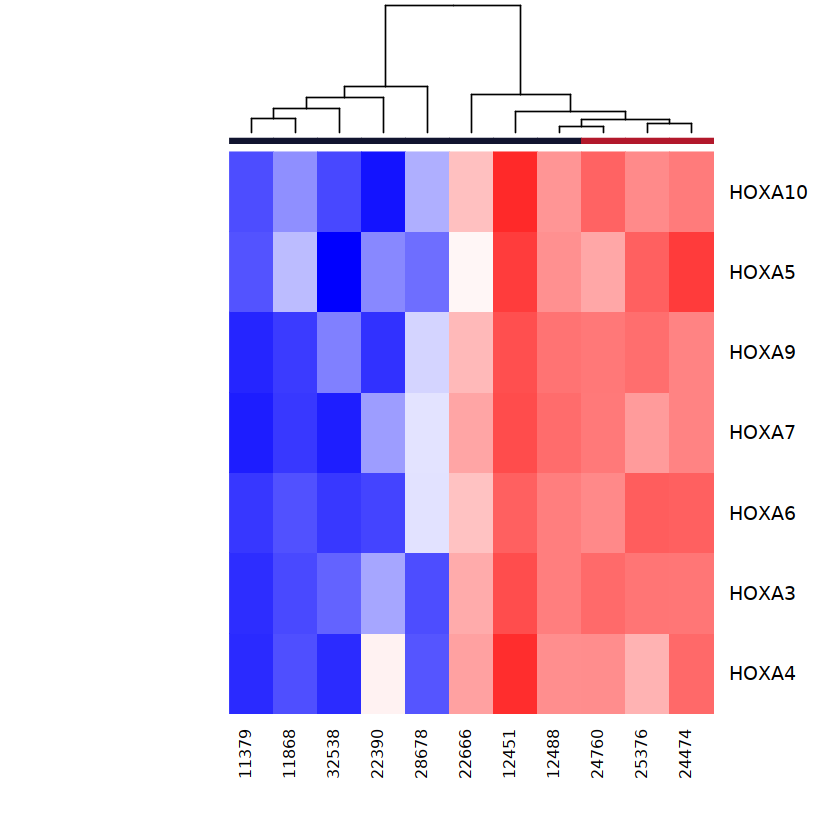

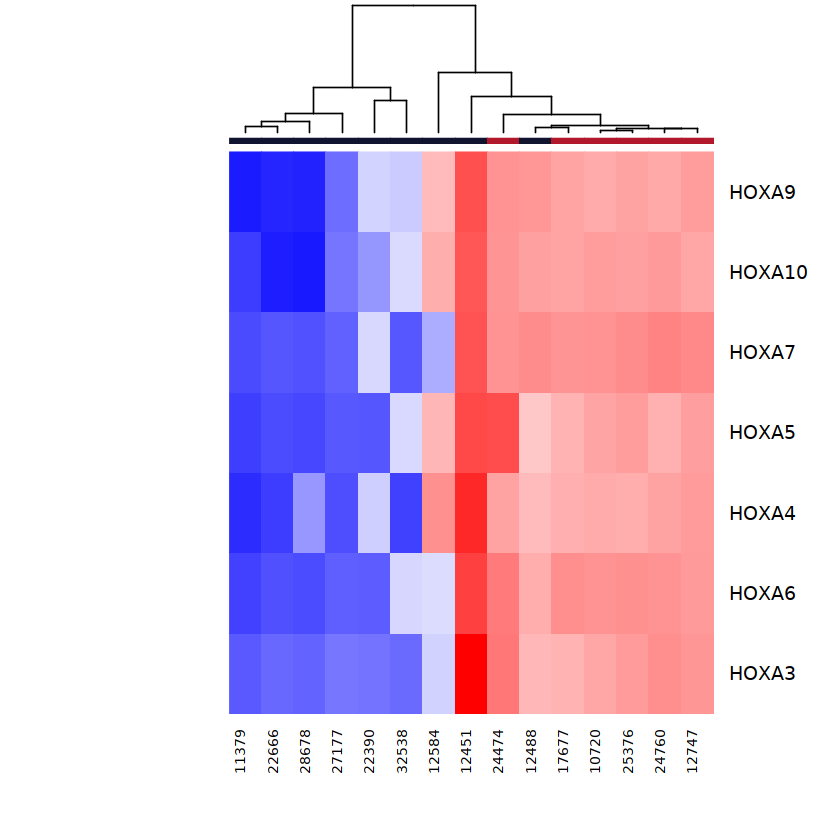

In [28]:
HOXA_gns <- topTable_PedAMLvsPedNL_Prog$SYMBOL[grep("HOXA", topTable_PedAMLvsPedNL_Prog$SYMBOL)]
HOXA_gns_filt.prog <- HOXA_gns_filt.stem <- HOXA_gns

options(repr.plot.width=7, repr.plot.height=7)
plotTopHeatmapForGenelist(gModeratedVoomedFitForContrasts.stem, gVoomResult.stem, 
                          genelist=HOXA_gns_filt.stem, geneNaId="SYMBOL", outputDir=gOutputDir,
                          metadataVector=gGroupMetadataVector.stem, coeffNumber=2, expGroups=c("PedAML", "PedNL"), 
                          colid="Patient.ID")
plotTopHeatmapForGenelist(gModeratedVoomedFitForContrasts.prog, gVoomResult.prog, 
                          genelist=HOXA_gns_filt.prog, geneNaId="SYMBOL", outputDir=gOutputDir,
                          metadataVector=gGroupMetadataVector.prog, coeffNumber=2, expGroups=c("PedAML", "PedNL"), 
                           colid="Patient.ID")


## Fig S5a - Barplot of Spliceosome Component Genes

In [29]:
spl_db <- read.csv("../data/SpliceosomeDB_HumanProteins.csv", header=TRUE, stringsAsFactors=FALSE)
spl_db_uni <- unique(spl_db$Gene.Symbol)
spl_db_ens <- spl_db$Ensemble.Gene.ID
spl_db_cats <- c("17S U2 snRNP", "17S U2 snRNP associated", 
            "alternative splicing factor", "anaphase promoting complex", "chaperonin/heat shock", 
            "chromatin-related", "coatomer protein complex", "common MS contaminants", "CPSF", "CSTF", "EJC/mRNP",
            "exocyst", "exosome", "GEM","hnRNP", "integrator complex", "linked to splicing ", "LSm", 
            "misc. proteins found irregularly with spliceosomes", "nuclear import/export machinery", 
            "nuclear pore complex", "Occasionally detected in Bact complex", "Occasionally detected in C complex", 
            "other rna binding domain containing", "pre-mRNA/mRNA binding proteins", "proteosome", "PRP19 complex", 
            "PRP19 related", "Recruited at A complex", "Recruited at B complex", "Recruited at Bact complex", 
            "Recruited at C complex", "RES complex", "ribosome", "Second step factors", "Sm", 
            "SMARC- chromatin-related", "SR protein", "SR related", "translation-related", "TREX",
            "tri-snRNP","U1 snRNP","U11/U12 snRNP", "U4/U6 recycling", "U4/U6 snRNP","U5 snRNP")
spl_db_test <- spl_db[spl_db$Class...family %in% c("", "17S U2 snRNP", "17S U2 snRNP associated", 
            "alternative splicing factor", "chaperonin/heat shock", 
            "CPSF", "CSTF", "EJC/mRNP",
            "exocyst", "exosome", "GEM","hnRNP", "integrator complex", "linked to splicing ", "LSm", 
            "misc. proteins found irregularly with spliceosomes", 
            "Occasionally detected in Bact complex", "Occasionally detected in C complex", 
            "other rna binding domain containing", "pre-mRNA/mRNA binding proteins", "proteosome", "PRP19 complex", 
            "PRP19 related", "Recruited at A complex", "Recruited at B complex", "Recruited at Bact complex", 
            "Recruited at C complex", "RES complex", "ribosome", "Second step factors", "Sm", 
            "SR protein", "SR related", "translation-related", "TREX",
            "tri-snRNP","U1 snRNP","U11/U12 snRNP", "U4/U6 recycling", "U4/U6 snRNP","U5 snRNP"),]
spl_db_test2 <- spl_db[spl_db$Class...family %in% c("", "hnRNP", "SR protein", "U1 snRNP", "U5 snRNP",
                                                    "U11/U12 snRNP", "17S U2 snRNP", "17S U2 snRNP associated", 
                                                   "pre-mRNA/mRNA binding proteins"
                                                   ),]
spl_db_test3 <- spl_db[spl_db$Class...family %in% c("", "hnRNP", "SR protein", "U1 snRNP", "U5 snRNP",
                                                    "U11/U12 snRNP", "17S U2 snRNP", "17S U2 snRNP associated", 
                                                   "pre-mRNA/mRNA binding proteins", "alternative splicing factor"
                                                   ),]
spl_db_ens_test <- spl_db_test2$Ensemble.Gene.ID
spl_db_sym_test <- spl_db_test2$Gene.Symbol
spl_db_ens_int <- spl_db_ens[spl_db_ens %in% topTable_PedAMLvsAdultAML_Prog$ENSEMBL[abs(topTable_PedAMLvsAdultAML_Prog$AveExpr) > 7]]


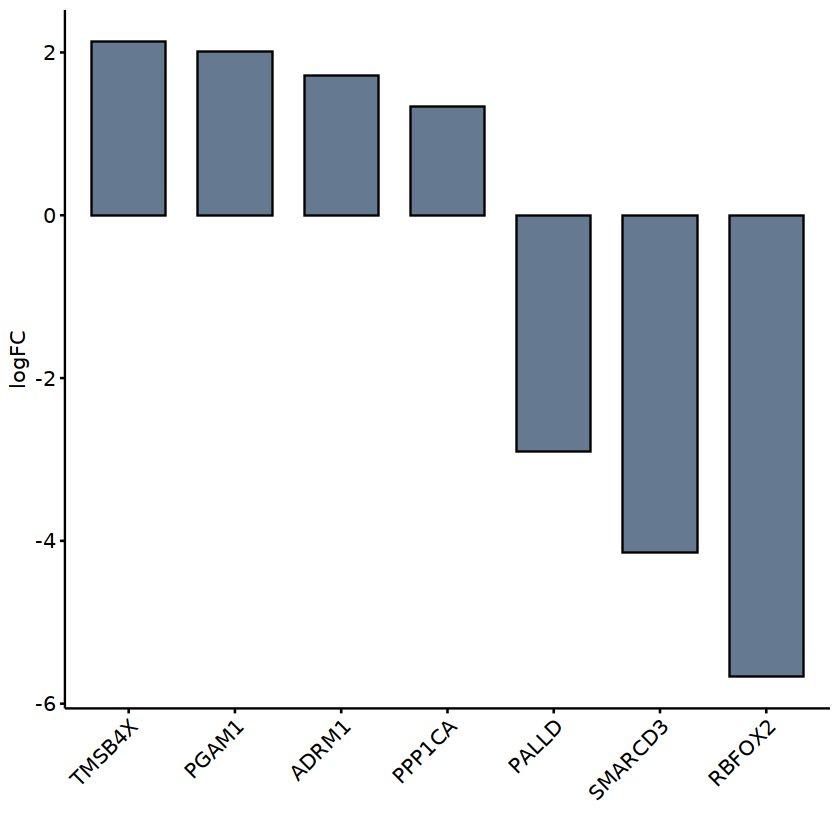

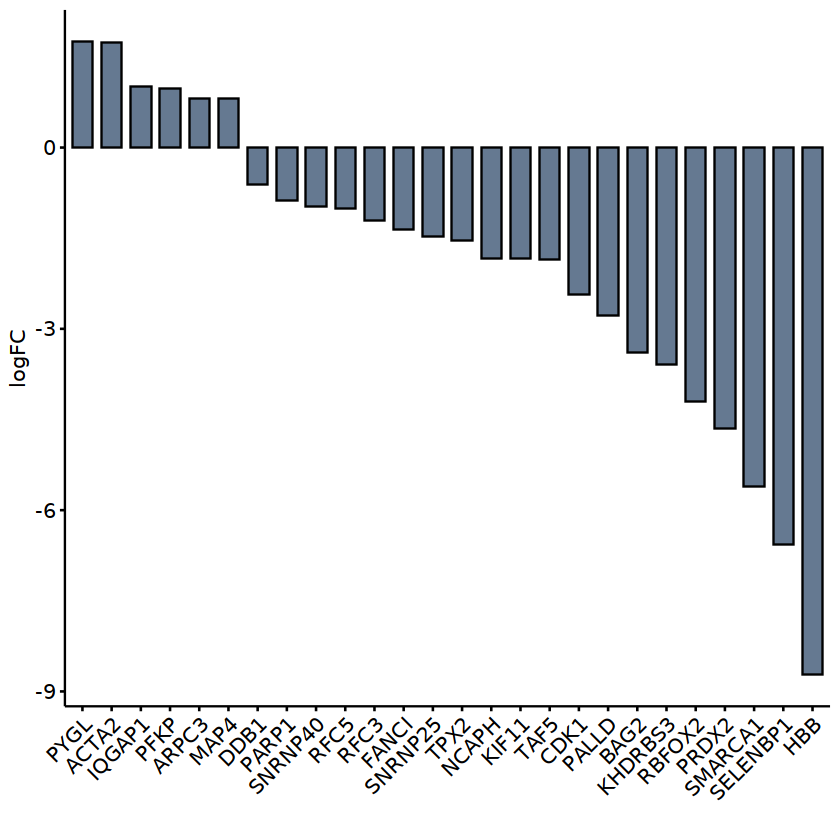

In [30]:
DE_splDB_plotinp_Prog <- topTable_PedAMLvsPedNL_Prog[topTable_PedAMLvsPedNL_Prog$adj.P.Val < 0.05 & 
                                                     topTable_PedAMLvsPedNL_Prog$SYMBOL %in% spl_db_test3$Gene.Symbol,]
DE_splDB_plotinp_Stem <- topTable_PedAMLvsPedNL_Stem[topTable_PedAMLvsPedNL_Stem$adj.P.Val < 0.05 &
                                                     topTable_PedAMLvsPedNL_Stem$SYMBOL %in% spl_db_test3$Gene.Symbol,]
DE_splDB_plotinp_Prog$SYMBOL <- as.character(DE_splDB_plotinp_Prog$SYMBOL)
DE_splDB_plotinp_Stem$SYMBOL <- as.character(DE_splDB_plotinp_Stem$SYMBOL)
ggbarplot(DE_splDB_plotinp_Stem[order(DE_splDB_plotinp_Stem$logFC, decreasing=TRUE),], x="SYMBOL", y="logFC", fill="#657991", xlab="") + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
ggbarplot(DE_splDB_plotinp_Prog[order(DE_splDB_plotinp_Prog$logFC, decreasing=TRUE),], x="SYMBOL", y="logFC", fill="#657991", xlab="") + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 


## Fig S5a - Boxplot of RBFOX2 (HSC, HPC)

In [31]:
RBFOX2.lcpm.prog <- cbind(gNormedFilteredDgeList.prog$samples, 
                        t(lcpm.prog[rownames(lcpm.prog) %in% "ENSG00000100320",,drop=FALSE]))
RBFOX2.lcpm.stem <- cbind(gNormedFilteredDgeList.stem$samples, 
                        t(lcpm.stem[rownames(lcpm.stem) %in% "ENSG00000100320",,drop=FALSE]))

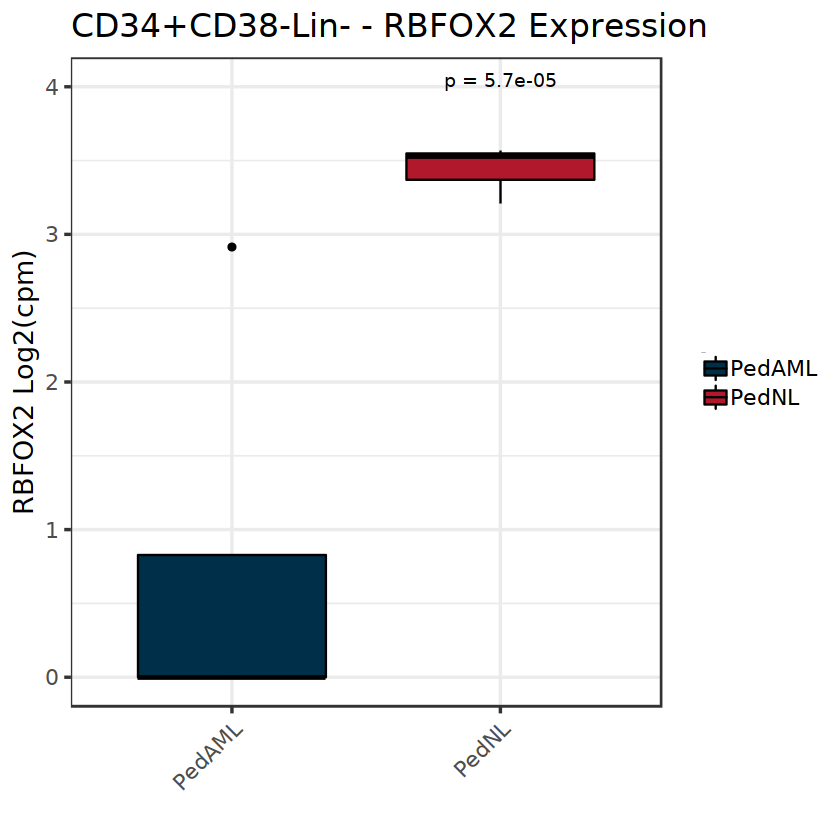

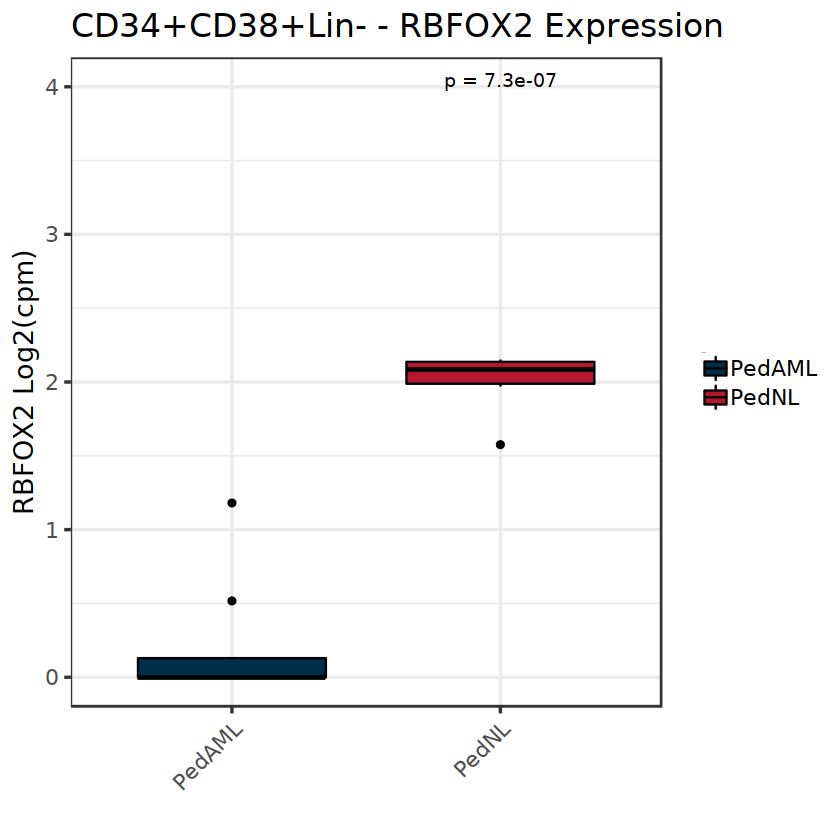

In [34]:
colnames(RBFOX2.lcpm.prog)[1] <- colnames(RBFOX2.lcpm.stem)[1] <- "Phenotype"
RBFOX2.lcpm.stem$ENSG00000100320[which(RBFOX2.lcpm.stem$ENSG00000100320 < 0)] <- 0
RBFOX2.lcpm.prog$ENSG00000100320[which(RBFOX2.lcpm.prog$ENSG00000100320 < 0)] <- 0

options(repr.plot.width=7, repr.plot.height=7)
ggboxplot(subset(RBFOX2.lcpm.stem, Phenotype != "AdultAML"), x="Phenotype", y="ENSG00000100320", 
          fill="Phenotype", palette=c("#003049","#B2182B")) +
    theme_bw(base_size=16) + ylab("RBFOX2 Log2(cpm)") + xlab("") + ylim(0,4) +
    labs(title="CD34+CD38-Lin- - RBFOX2 Expression") + theme(legend.title=element_text(size=0)) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    stat_compare_means(method="t.test", label = "p.format", ref.group="PedAML")

options(repr.plot.width=7, repr.plot.height=7)
ggboxplot(subset(RBFOX2.lcpm.prog[-12,], Phenotype != "AdultAML"), x="Phenotype", y="ENSG00000100320", 
          fill="Phenotype", palette=c("#003049","#B2182B")) +
    theme_bw(base_size=16) + ylab("RBFOX2 Log2(cpm)") + xlab("") + ylim(0,4) +
    labs(title="CD34+CD38+Lin- - RBFOX2 Expression") + theme(legend.title=element_text(size=0)) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    stat_compare_means(method="t.test", label = "p.format", ref.group="PedAML")





## Fig S5d - Heatmap of Alternative Splicing Factors (HSC)

Warning message in if (tolower(expGroups) == "all") {:
“the condition has length > 1 and only the first element will be used”


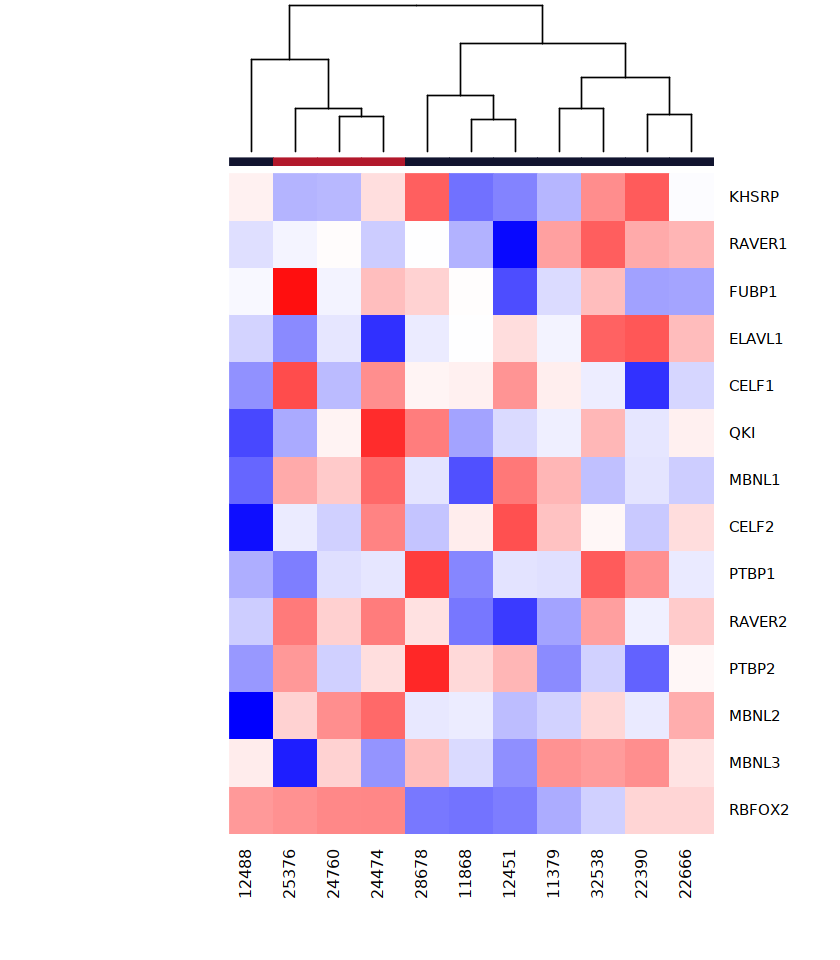

In [35]:
ASF <- c("RBFOX2","RAVER1","KHSRP","FUBP1","MBNL1","PTBP1","PTBP2","ELAVL1","MBNL2",
         "CELF1","CELF2","RAVER2", "MBNL3","QKI")
options(repr.plot.width=7, repr.plot.height=8)
plotTopHeatmapForGenelist(gModeratedVoomedFitForContrasts.stem, gVoomResult.stem, 
                          genelist=ASF, geneNaId="SYMBOL", outputDir=gOutputDir,
                          metadataVector=gGroupMetadataVector.stem, coeffNumber=2, 
                          colid="Patient.ID")


In [36]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/ubuntu/anaconda3/lib/libmkl_rt.so.1

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.1                          
 [2] gplots_3.1.1                           
 [3] reshape2_1.4.4                         
 [4] gdata_2.18.0                           
 [5] dplyr_1.0.7                            
 [6] plyr_1.8.6                             
 [7] statmod_1.4.36                         
 [8] splitstackshape_1.4.8       

[Table of Contents](#Table-of-Contents)

Copyright (c) 2018 UC San Diego Center for Computational Biology & Bioinformatics under the MIT License

Notebook template by Amanda Birmingham